# Серия экспериментов с разными наборами признаков для объединенного датасета

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import sys, os
import pathlib
from pathlib import Path
from pydantic import ValidationError
from olist_churn_prediction.paths import SRC_DIR, PROCESSED_DIR, INTERIM_DIR, RAW_DIR
from olist_churn_prediction.schemas_interim import MergedDfSchemaInterim
from olist_churn_prediction import feature_processing
from sklearn.model_selection import StratifiedKFold, cross_val_predict
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

import mlflow

In [122]:
mlflow.autolog()

2025/07/29 19:12:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/07/29 19:12:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/07/29 19:12:17 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.14.1 <= statsmodels <= 0.14.4, but the installed version is 0.14.5. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/07/29 19:12:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [126]:
pd.set_option('display.max_columns', None)

In [127]:
df = pd.read_parquet(INTERIM_DIR / "merged_churn_interim.parquet")

for i, row in df.head(5).iterrows():
    try:
        MergedDfSchemaInterim.model_validate(row.to_dict())
    except ValidationError as e:
        print(f"\nRow {i}:\n{e}\n")


Row 0:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 1:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 2:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=0, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 3:
1 validation error for MergedDfSchemaInterim
churned
  Extra inputs are not permitted [type=extra_forbidden, input_value=1, input_type=int]
    For further information visit https://errors.pydantic.dev/2.11/v/extra_forbidden


Row 4:
1 validation error for MergedDfSchemaInterim
churned
  E

In [128]:
df = feature_processing.load_data(INTERIM_DIR / "merged_churn_interim.parquet",
                      schema = MergedDfSchemaInterim,
                      validate = False)

In [129]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93882 entries, 0 to 93881
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       93882 non-null  string        
 1   order_products_value           93882 non-null  float32       
 2   order_freight_value            93882 non-null  float32       
 3   order_items_qty                93882 non-null  Int64         
 4   product_photos_qty             93882 non-null  Int64         
 5   product_name_lenght            93882 non-null  Float64       
 6   product_description_lenght     93882 non-null  Float64       
 7   review_creation_date           93882 non-null  datetime64[ns]
 8   review_answer_timestamp        93882 non-null  datetime64[ns]
 9   order_purchase_timestamp       93882 non-null  datetime64[ns]
 10  order_aproved_at               93882 non-null  datetime64[ns]
 11  order_estimated

None

In [130]:
df = df.rename(columns={'value': 'summary_payments_value', 'product_name_lenght': 'product_name_length', 'product_description_lenght': 'product_description_length'})

In [131]:
display(df.head())

,order_id,order_products_value,order_freight_value,order_items_qty,product_photos_qty,product_name_length,product_description_length,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,customer_city,customer_state,customer_zip_code_prefix,product_id,review_id,review_score,product_category_name_english,summary_payments_value,installments,sequential,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,seller_id,seller_zip_code_prefix,seller_city,seller_state,churned
0,0000f01da58c553799200eb71eb0563b,54.900002,18.000000,1,3,58.0,1146.0,2018-01-17,2018-01-18 11:25:59,2017-12-20 16:02:06,2017-12-22 02:38:38.513998,2018-01-16,2018-01-16 22:28:47.059813,aaf96a43700cc28f3d1f6115e9bf311e,sao_jose_dos_campos,sp,122,d363e421b1d15376b299089946fed127,0000f01da58c553799200eb71eb0563b,3,furniture_living_room,72.900002,1,1,3200.0,30.0,11.0,30.0,366d0f35dec4298dce6b76abb9b214ec,870d0118f7a9d85960f29ad89d5d989a,377,pocos_de_caldas,mg,1
1,00010242fe8c5a6d1ba2dd792cb16214,58.900002,13.290000,1,4,58.0,627.0,2017-09-21,2017-09-22 13:57:03,2017-09-13 08:59:02,2017-09-13 09:45:35.019805,2017-09-29,2017-09-20 23:43:48.274761,3ce436f183e68e07877b285a838db11a,campos_dos_goytacazes,rj,280,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,5,cool_stuff,72.190002,2,1,550.0,25.0,7.0,11.0,d71416e1848ae3efa978c0bea9704733,48436dade18ac8b2bce089ec2a041202,272,volta_redonda_1,sp,1
2,00026c8a4fe2c14efa2afe807921981c,389.980011,87.300003,2,4,47.0,417.0,2018-08-05,2018-08-05 15:07:49,2018-07-20 04:39:11,2018-07-21 03:15:19.821915,2018-08-20,2018-08-04 00:16:50.549625,a7785a0278913274fddadfb4010eb59e,lagoa_grande_1,pe,563,9bf49e13f79afe62919c79d125d81cf8,00026c8a4fe2c14efa2afe807921981c,5,garden_tools,477.279999,1,1,1150.0,22.0,21.0,16.0,ee54aa475334c71b07ab5a1055699f38,dfc5fb7259bb2b599ca565e6e9448f0f,097,sao_bernardo_do_campo,sp,0
3,000312d02b605a8a630c3a9882793ffb,600.000000,73.199997,4,10,60.0,1632.0,2017-09-30,2017-10-03 01:41:10,2017-09-19 12:16:14,2017-09-19 12:30:10.302973,2017-10-10,2017-09-29 19:12:27.606354,d54487c6cb43a7ae702eac4adc1d9224,piuma,es,292,588ea3decc0d8e1d19ce6160c5b0da1b,000312d02b605a8a630c3a9882793ffb,5,housewares,673.200012,10,1,1350.0,43.0,18.0,18.0,fb7ac054945d4ead94959436e74aadca,955fee9216a65b617aa5c0531780ce60,047,sao_paulo,sp,1
4,000330af600103828257923c9aa98ae2,59.489998,33.700001,2,7,49.0,1429.0,2017-12-10,2017-12-15 02:58:44,2017-11-13 22:59:54,2017-11-13 23:10:40.663223,2017-12-13,2017-12-09 16:42:14.232409,fad0bbc7d520cbb3c5b67d4d4b546826,barra_de_sao_joao,rj,288,8dacd980e54f23aaaa6bb4f33478664e,000330af600103828257923c9aa98ae2,4,housewares,0.000000,0,0,1600.0,30.0,30.0,30.0,225bffd033b6dae803fc04f6e83751fc,53e4c6e0f4312d4d2107a8c9cddf45cd,139,pedreira,sp,1


## Построение baseline-модели

Сначала построим разные модели с одним набором базовых признаков.

In [64]:
ids_features = ['order_id', 'customer_id', 'customer_unique_id', 'product_id', 'review_id', 'seller_id', 'seller_zip_code_prefix', 'customer_zip_code_prefix']
categorical_features = df.select_dtypes(include=["object", "string"]).columns.drop(ids_features).tolist()
numeric_features = df.select_dtypes(include=["int", "float"]).columns.tolist()
time_features = df.select_dtypes(include=["datetime64[ns]"]).columns.tolist()
target = ['churned']
baseline_features = df.columns.drop(ids_features).drop(time_features).drop(target).tolist()

In [65]:
X = df[baseline_features]
y = df['churned']

In [67]:
len(df['product_category_name_english'].value_counts())

71

In [68]:
len(df['seller_city'].value_counts())

468

In [69]:
len(df['customer_city'].value_counts())

4288

In [70]:
corr_matrix = df[numeric_features].corr()

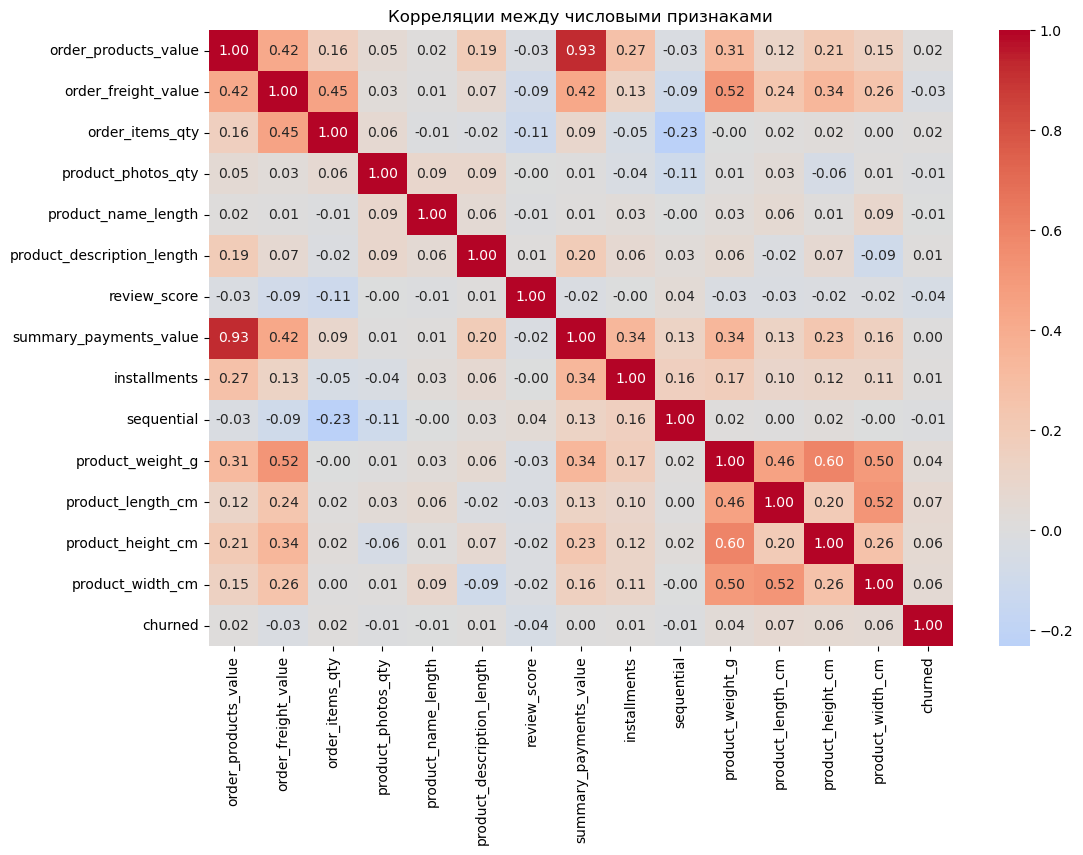

In [71]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Корреляции между числовыми признаками")
plt.show()

### Кодирование категориальных признаков 

Мы однозначно кодируем state с помощью OneHotEncoder, так как в нем немного разных категорий. city-признаки содержат более 5000 категорий, поэтому one-hot не подойдет. То же можно сказать и для product_category_name_english на 71 категорию. Попробуем разные подходы кодирования, проверим прирост метрики, зафиксируем и решим оставлять эти признаки или нет.

In [72]:
def target_encode_oof(X, y, col, n_splits=5, alpha=10, seed=42):
    skf = StratifiedKFold(n_splits, shuffle=True, random_state=seed)
    global_mean = y.mean()
    te_oof = pd.Series(index=X.index, dtype=float)

    for tr_idx, val_idx in skf.split(X, y):
        tmp = pd.DataFrame({col: X.iloc[tr_idx][col],
                            'target': y.iloc[tr_idx]})

        stats = (tmp.groupby(col)['target']
                    .agg(['sum', 'count']))
        stats['te'] = (stats['sum'] + alpha*global_mean) / (stats['count'] + alpha)
        mapping = stats['te']

        te_oof.iloc[val_idx] = (
            X.iloc[val_idx][col]
              .map(mapping)
              .fillna(global_mean)
        )

    # финальный mapping для теста / продакшена
    full_stats = pd.DataFrame({col: X[col], 'target': y}).groupby(col)['target'].agg(['sum', 'count'])
    full_stats['te'] = (full_stats['sum'] + alpha*global_mean) / (full_stats['count'] + alpha)
    mapping_full = full_stats['te']

    return te_oof, mapping_full

In [73]:
y_cols = ['customer_city', 'seller_city', 'product_category_name_english']
for c in y_cols:
    te_oof, mapping_full = target_encode_oof(X, y, c, 5, alpha)  # функция из прошлого ответа
    X[c + '_te'] = te_oof
    X.drop(columns=[c], inplace=True)

C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_6156\1221171195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[c + '_te'] = te_oof
C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_6156\1221171195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=[c], inplace=True)
C:\Users\Вячеслав\AppData\Local\Temp\ipykernel_6156\1221171195.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [79]:
te_cols = ['product_category_name_english_te', 'seller_city_te', 'customer_city_te']
ohe_cols = ['customer_state', 'seller_state']

In [114]:
col_tf = ColumnTransformer(
    transformers=[
        ('other', 'passthrough', X.columns.drop(ohe_cols)),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True), ohe_cols) 
    ]
)

In [115]:
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [117]:
X_test.shape

(15021, 19)

In [118]:
model = LGBMClassifier(random_state=42)

In [119]:
pipe  = Pipeline([('prep', col_tf),
                  ('clf',  model)])

In [124]:
pipe.fit(X_train, y_train)

2025/07/29 19:19:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5c79317ddf1e49e4abf607dc604ae66e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/07/29 19:19:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\anaconda\envs\olist-ml\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <htt

[LightGBM] [Info] Number of positive: 51873, number of negative: 8211
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2610
[LightGBM] [Info] Number of data points in the train set: 60084, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.863341 -> initscore=1.843324
[LightGBM] [Info] Start training from score 1.843324


C:\anaconda\envs\olist-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\anaconda\envs\olist-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\anaconda\envs\olist-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\anaconda\envs\olist-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\anaconda\envs\olist-ml\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\anaconda\envs\olist-ml\Lib\

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('other', ...), ('ohe', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
X.head()

,order_products_value,order_freight_value,order_items_qty,product_photos_qty,product_name_length,product_description_length,customer_state,review_score,summary_payments_value,installments,sequential,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_state,customer_city_te,seller_city_te,product_category_name_english_te
0,54.900002,18.000000,1,3,58.0,1146.0,sp,3,72.900002,1,1,3200.0,30.0,11.0,30.0,mg,0.853845,0.875092,0.916272
1,58.900002,13.290000,1,4,58.0,627.0,rj,5,72.190002,2,1,550.0,25.0,7.0,11.0,sp,0.903824,0.971062,0.930639
2,389.980011,87.300003,2,4,47.0,417.0,pe,5,477.279999,1,1,1150.0,22.0,21.0,16.0,sp,0.863041,0.741820,0.887523
3,600.000000,73.199997,4,10,60.0,1632.0,es,5,673.200012,10,1,1350.0,43.0,18.0,18.0,sp,0.896974,0.854376,0.849462
4,59.489998,33.700001,2,7,49.0,1429.0,rj,4,0.000000,0,0,1600.0,30.0,30.0,30.0,sp,0.859600,0.843565,0.847339


In [41]:
print(df['order_id'].value_counts().head())

order_id
0000f01da58c553799200eb71eb0563b    1
00010242fe8c5a6d1ba2dd792cb16214    1
00026c8a4fe2c14efa2afe807921981c    1
000312d02b605a8a630c3a9882793ffb    1
000330af600103828257923c9aa98ae2    1
Name: count, dtype: Int64


In [42]:
print(df['customer_id'].value_counts().head())

customer_id
aaf96a43700cc28f3d1f6115e9bf311e    1
3ce436f183e68e07877b285a838db11a    1
a7785a0278913274fddadfb4010eb59e    1
d54487c6cb43a7ae702eac4adc1d9224    1
fad0bbc7d520cbb3c5b67d4d4b546826    1
Name: count, dtype: Int64


In [43]:
print(df['product_id'].value_counts().head())

product_id
99a4788cb24856965c36a24e339b6058    606
aca2eb7d00ea1a7b8ebd4e68314663af    601
422879e10f46682990de24d770e7f83d    453
d1c427060a0f73f6b889a5c7c61f2ac4    430
53b36df67ebb7c41585e8d54d6772e08    421
Name: count, dtype: Int64


In [44]:
print(df['review_id'].value_counts().head())

review_id
0000f01da58c553799200eb71eb0563b    1
00010242fe8c5a6d1ba2dd792cb16214    1
00026c8a4fe2c14efa2afe807921981c    1
000312d02b605a8a630c3a9882793ffb    1
000330af600103828257923c9aa98ae2    1
Name: count, dtype: Int64


In [45]:
print(df['customer_unique_id'].value_counts().head())

customer_unique_id
ff4ea78481e00334563aea6d1681f496    10
b6169cb608e0a9d1b0ed53b93fe21713     9
915f2fe0968adc3e5a76d70ca9326bf5     9
779ab1cce17159b31d6a0a4694644455     8
876c06b735eded4e35e1975200afd3aa     7
Name: count, dtype: Int64


In [46]:
print(df['seller_id'].value_counts().head())

seller_id
6560211a19b47992c3666cc44a7e94c0    2710
4a3ca9315b744ce9f8e9374361493884    2430
cc419e0650a3c5ba77189a1882b7556a    2234
1f50f920176fa81dab994f9023523100    1915
da8622b14eb17ae2831f4ac5b9dab84a    1859
Name: count, dtype: Int64


In [48]:
display(df.head())

,order_id,order_products_value,order_freight_value,order_items_qty,product_photos_qty,product_name_lenght,product_description_lenght,review_creation_date,review_answer_timestamp,order_purchase_timestamp,order_aproved_at,order_estimated_delivery_date,order_delivered_customer_date,customer_id,customer_city,customer_state,customer_zip_code_prefix,product_id,review_id,review_score,product_category_name_english,value,installments,sequential,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,seller_id,seller_zip_code_prefix,seller_city,seller_state,churned
0,0000f01da58c553799200eb71eb0563b,54.900002,18.000000,1,3,58.0,1146.0,2018-01-17,2018-01-18 11:25:59,2017-12-20 16:02:06,2017-12-22 02:38:38.513998,2018-01-16,2018-01-16 22:28:47.059813,aaf96a43700cc28f3d1f6115e9bf311e,sao_jose_dos_campos,sp,122,d363e421b1d15376b299089946fed127,0000f01da58c553799200eb71eb0563b,3,furniture_living_room,72.900002,1,1,3200.0,30.0,11.0,30.0,366d0f35dec4298dce6b76abb9b214ec,870d0118f7a9d85960f29ad89d5d989a,377,pocos_de_caldas,mg,1
1,00010242fe8c5a6d1ba2dd792cb16214,58.900002,13.290000,1,4,58.0,627.0,2017-09-21,2017-09-22 13:57:03,2017-09-13 08:59:02,2017-09-13 09:45:35.019805,2017-09-29,2017-09-20 23:43:48.274761,3ce436f183e68e07877b285a838db11a,campos_dos_goytacazes,rj,280,4244733e06e7ecb4970a6e2683c13e61,00010242fe8c5a6d1ba2dd792cb16214,5,cool_stuff,72.190002,2,1,550.0,25.0,7.0,11.0,d71416e1848ae3efa978c0bea9704733,48436dade18ac8b2bce089ec2a041202,272,volta_redonda_1,sp,1
2,00026c8a4fe2c14efa2afe807921981c,389.980011,87.300003,2,4,47.0,417.0,2018-08-05,2018-08-05 15:07:49,2018-07-20 04:39:11,2018-07-21 03:15:19.821915,2018-08-20,2018-08-04 00:16:50.549625,a7785a0278913274fddadfb4010eb59e,lagoa_grande_1,pe,563,9bf49e13f79afe62919c79d125d81cf8,00026c8a4fe2c14efa2afe807921981c,5,garden_tools,477.279999,1,1,1150.0,22.0,21.0,16.0,ee54aa475334c71b07ab5a1055699f38,dfc5fb7259bb2b599ca565e6e9448f0f,097,sao_bernardo_do_campo,sp,0
3,000312d02b605a8a630c3a9882793ffb,600.000000,73.199997,4,10,60.0,1632.0,2017-09-30,2017-10-03 01:41:10,2017-09-19 12:16:14,2017-09-19 12:30:10.302973,2017-10-10,2017-09-29 19:12:27.606354,d54487c6cb43a7ae702eac4adc1d9224,piuma,es,292,588ea3decc0d8e1d19ce6160c5b0da1b,000312d02b605a8a630c3a9882793ffb,5,housewares,673.200012,10,1,1350.0,43.0,18.0,18.0,fb7ac054945d4ead94959436e74aadca,955fee9216a65b617aa5c0531780ce60,047,sao_paulo,sp,1
4,000330af600103828257923c9aa98ae2,59.489998,33.700001,2,7,49.0,1429.0,2017-12-10,2017-12-15 02:58:44,2017-11-13 22:59:54,2017-11-13 23:10:40.663223,2017-12-13,2017-12-09 16:42:14.232409,fad0bbc7d520cbb3c5b67d4d4b546826,barra_de_sao_joao,rj,288,8dacd980e54f23aaaa6bb4f33478664e,000330af600103828257923c9aa98ae2,4,housewares,0.000000,0,0,1600.0,30.0,30.0,30.0,225bffd033b6dae803fc04f6e83751fc,53e4c6e0f4312d4d2107a8c9cddf45cd,139,pedreira,sp,1


In [ ]:
diffs = FeatureUnion([
    ('payment_lag', DateDiffTransformer('order_purchase_timestamp',
                                        'order_aproved_at',
                                        'payment_lag_hours')),
    ('estimated_shipping_lag', DateDiffTransformer('order_aproved_at',
                                         'order_estimated_delivery_date',
                                         'estimated_shipping_lag_hours')),
    ('actual_and_estimated_shipping_lag', DateDiffTransformer('order_estimated_delivery_date',
                                         'order_delivered_customer_date',
                                         'actual_and_estimated_shipping_lag_hours')),
    ('customer_review_response_lag', DateDiffTransformer('review_creation_date',
                                         'review_answer_timestamp',
                                         'customer_review_response_lag_hours')),
    ('approval_and_arrival_lag', DateDiffTransformer('order_aproved_at',
                                         'order_delivered_customer_date',
                                         'approval_and_arrival_lag_hours')),
])